<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/TimesFM/Quick_inference_with_Google'sTimesFM_on_a_CSV_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inference with Google's TimesFM model for time series forecasting

In this notebook, we will be testing Google's [TimesFM](i) (Time Series Foundation Model) for the task of time-series forecasting. Given it is now available in the [Transformers library](https://huggingface.co/docs/transformers/model_doc/timesfm), we can use it in just a few lines of code!

TimesFM is very similar to a GPT model, except it is trained to predict the next values in a time-series, as opposed to the next text token. The model is pre-trained on a large collection of time-series collected by Google. This involves both synthetic data as well as 100 billion actual time-points from various domains like [Google Trends](https://trends.google.com/trends/) and [Wikipedia Page views](https://meta.wikimedia.org/wiki/Research:Page_view).

After pre-training, we can use it to predict new values for a given time-series. This is called "zero-shot prediction" since we don't update the weights of the model, we just use it out-of-the-box for making predictions on new, unseen data, much like prompting a large language model (LLM) or vision-language model (VLM). Interestingly, the authors claim that it outperforms models like DeepAR which are explicitly trained on time-series.

The [blog post](https://research.google/blog/a-decoder-only-foundation-model-for-time-series-forecasting/) is a great explainer for knowing how TimesFM works. The idea is to "patchfiy" a time-series into smaller pieces which serve as the "tokens".

- Docs: https://huggingface.co/docs/transformers/model_doc/timesfm
- Github repository: https://github.com/google-research/timesfm.

## Set-up environment

Let's start by installing 🤗 Transformers. Make sure to set "runtime" to "GPU" for faster computation.

In [ ]:
!pip install -q --upgrade datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-

## Load model

Next, we load a pre-trained TimesFM model from the hub. In this case we load a model with 500M parameters.

We also specify some additional parameters, namely:
- load the model in bfloat16 precision (this reduces the memory usage)
- use the ["sdpa"](https://docs.pytorch.org/tutorials/intermediate/scaled_dot_product_attention_tutorial.html) version of attention, for faster attention computation
- put it on the GPU, if available.

In [ ]:
import torch
from transformers import TimesFmModelForPrediction

model = TimesFmModelForPrediction.from_pretrained(
    "google/timesfm-2.0-500m-pytorch",
    attn_implementation="sdpa",
    device_map="cuda" if torch.cuda.is_available() else None
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/692 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

Note that this TimesFM model has been pre-trained on context lengths up to 2048 timepoints and any horizon lengths. By default, the model will predict 128 values into the future. This can be observed in the model's configuration:

In [ ]:
print("Context length:", model.config.context_length)
print("Horizon (prediction) length:", model.config.horizon_length)

Context length: 2048
Horizon (prediction) length: 128


The model will then split up time series into smaller "patches" based on its patch length. Note that the model's patch length (32) is a number that is a divisor of the model's context length (2048).

In [ ]:
print("Patch length:", model.config.patch_length)

Patch length: 32


## Load dataset

Let's load a dataset containing time series values on which we want to make predictions. For the sake of demonstration, we've collected a simple "electricity production" dataset which we made available [here](https://huggingface.co/datasets/huggingface/electricity-production).

Note that you can easily load your own CSV (or other formatted) data as shown [here](https://huggingface.co/docs/datasets/en/loading#csv).

In [ ]:
from datasets import load_dataset

dataset = load_dataset("huggingface/electricity-production", split="train")

README.md:   0%|          | 0.00/547 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.75k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/397 [00:00<?, ? examples/s]

As can be seen, the dataset consists of 397 values of electricity production, from 1985 to 2018:

In [ ]:
print(dataset)

Dataset({
    features: ['DATE', 'IPG2211A2N'],
    num_rows: 397
})


In [ ]:
print(dataset[0])
print(dataset[-1])

{'DATE': '1/1/1985', 'IPG2211A2N': 72.5052}
{'DATE': '1/1/2018', 'IPG2211A2N': 129.4048}


Let's split up the dataset into:
- a dataset which we will use as "context" or "prompt"
- another dataset which we can use for testing, i.e. compare the model's predictions to the ground truth values.

In [ ]:
dataset = dataset.train_test_split(test_size=0.1, shuffle=False) # shuffle is False as to not mix the temporal ordering
prompt_dataset = dataset["train"]
test_dataset = dataset["test"] # last 0.1 of the time steps for testing

## Predict



In order to make a prediction, we need to turn the data into `past_values` which is a PyTorch tensor of shape (batch_size, number_of_values), in our case (1, 357). This fits into the model's context length of 2048.

Next to that, we also provide the `frequence_id` argument which indicates the frequency of the values. Refer to the [README](https://github.com/google-research/timesfm/tree/5950ef0653e4ff142a80906a08432cc457a2ace9?tab=readme-ov-file#perform-inference) for a detailed explanation on this parameter. Here we use "1: medium frequency time series. We recommend using this for weekly and monthly data".


In [ ]:
model.eval() # note: from_pretrained already sets the model in evaluation mode, but doesn't hurt to do it twice
past_values = torch.tensor(prompt_dataset['IPG2211A2N']).unsqueeze(0).to(device=model.device)
frequency_id = [[1]] # as the freq is Monthly

print(past_values.shape)

torch.Size([1, 357])


 Next we can use the model to make predictions on a set of data. Since the dataset is a single time series we can just call the model on it (perform a single forward pass).

In [ ]:
with torch.no_grad():
  outputs = model(past_values=past_values, freq=frequency_id)

The model outputs both "mean predictions" (which are point forecasts) as well as "full_predictions" (which are probabilistic forecasts). By probabilisticm, we mean that the model outputs 10 so-called quantiles. The first quantile is a value for which the model thinks 10% of the distribution has a lower value. The last 90% quantile is a value for which the model thinks 90% of the distribution has a value below it.

In [ ]:
print(outputs.keys())

odict_keys(['last_hidden_state', 'mean_predictions', 'full_predictions'])


As the model has a horizon length of 128, we get 128 predicted values:

In [ ]:
print(outputs.mean_predictions.shape)

torch.Size([1, 128])


In [ ]:
print(outputs.full_predictions.shape)

torch.Size([1, 128, 10])


## Plot predictions

Next we can plot the model's predictions alongside the ground truth values, as we already know the future values.

Below we use the model's point predictions.

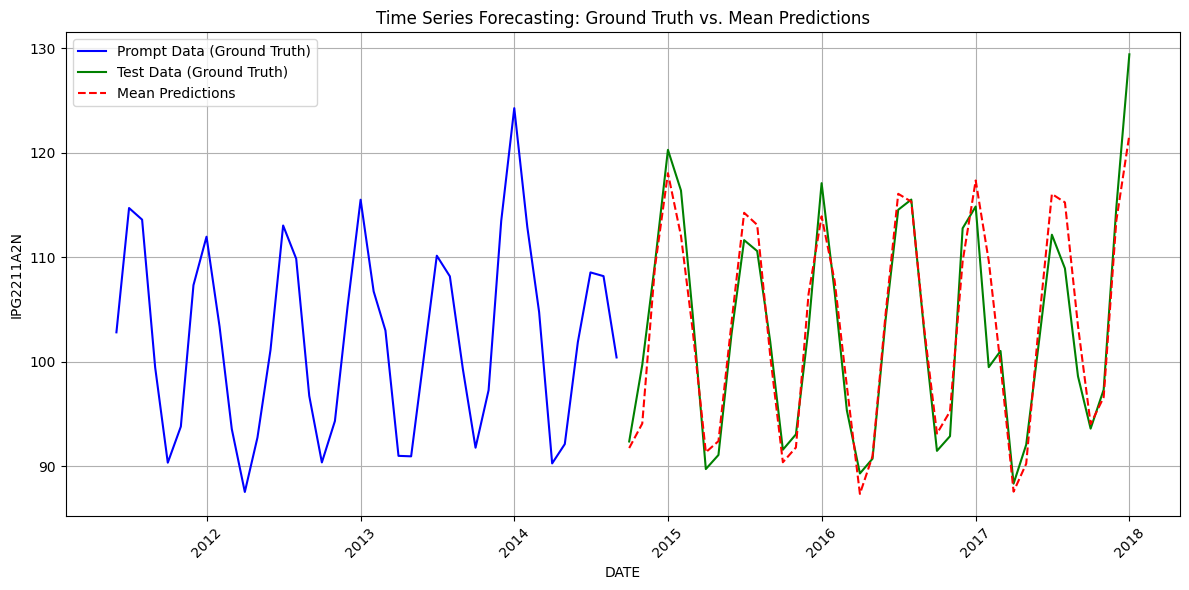

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the datasets to pandas DataFrames for easier plotting
prompt_df = pd.DataFrame(prompt_dataset)
test_df = pd.DataFrame(test_dataset)

# Convert the 'DATE' column to datetime objects
prompt_df['DATE'] = pd.to_datetime(prompt_df['DATE'])
test_df['DATE'] = pd.to_datetime(test_df['DATE'])

# Get the last 40 timesteps of the prompt dataset
last_40_prompt = prompt_df.tail(40)

# Get the predicted values and convert to numpy for plotting
predicted_values = outputs.mean_predictions[0].cpu().numpy()

# Get the ground truth values for the test set
ground_truth_test = test_df['IPG2211A2N']

# Create the plot
plt.figure(figsize=(12, 6))

# Plot the last 40 timesteps of the prompt dataset (ground truth)
plt.plot(last_40_prompt['DATE'], last_40_prompt['IPG2211A2N'], label='Prompt Data (Ground Truth)', color='blue')

# Plot the test dataset (ground truth)
plt.plot(test_df['DATE'], ground_truth_test, label='Test Data (Ground Truth)', color='green')

# Plot the predictions
# We need to align the predictions with the test set dates
plt.plot(test_df['DATE'], predicted_values[:len(test_df)], label='Mean Predictions', color='red', linestyle='--')

plt.xlabel('DATE')
plt.ylabel('IPG2211A2N')
plt.title('Time Series Forecasting: Ground Truth vs. Mean Predictions')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Besides that, we can also plot the probabilistic values (quantiles):

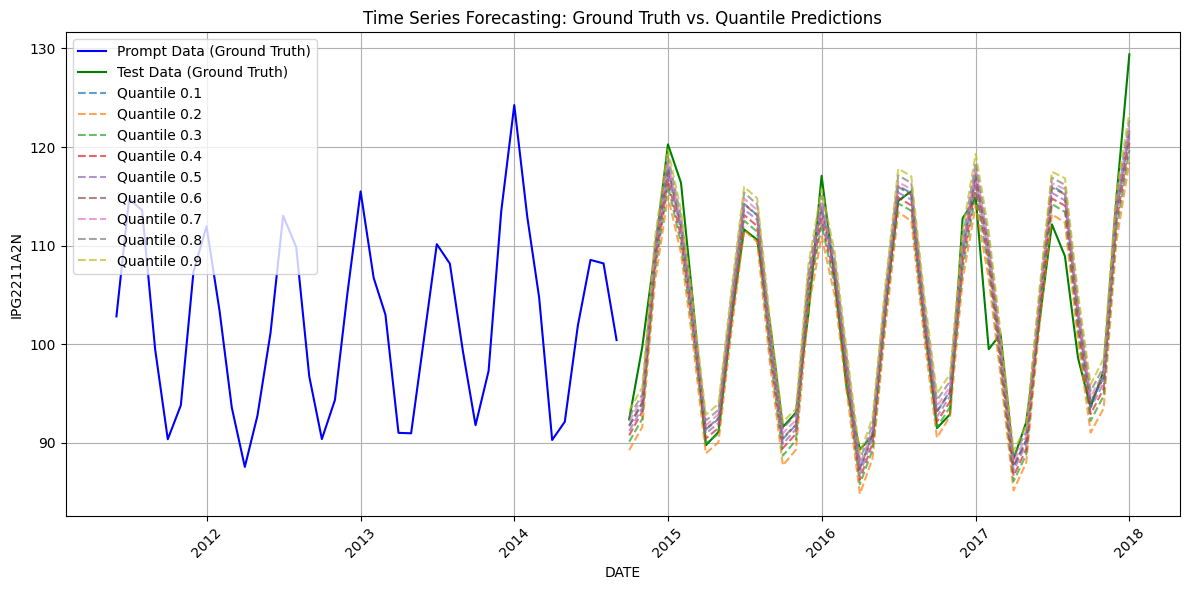

In [ ]:
import numpy as np

# Convert the datasets to pandas DataFrames for easier plotting
prompt_df = pd.DataFrame(prompt_dataset)
test_df = pd.DataFrame(test_dataset)

# Convert the 'DATE' column to datetime objects
prompt_df['DATE'] = pd.to_datetime(prompt_df['DATE'])
test_df['DATE'] = pd.to_datetime(test_df['DATE'])

# Get the last 40 timesteps of the prompt dataset
last_40_prompt = prompt_df.tail(40)

# Get the full predictions and convert to numpy for plotting
full_predictions = outputs.full_predictions[0].cpu().numpy() # Shape (num_timesteps, num_quantiles)

# Get the ground truth values for the test set
ground_truth_test = test_df['IPG2211A2N']

# Define the quantiles
quantiles = np.arange(0.1, 1.0, 0.1)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot the last 40 timesteps of the prompt dataset (ground truth)
plt.plot(last_40_prompt['DATE'], last_40_prompt['IPG2211A2N'], label='Prompt Data (Ground Truth)', color='blue')

# Plot the test dataset (ground truth)
plt.plot(test_df['DATE'], ground_truth_test, label='Test Data (Ground Truth)', color='green')

# Plot the quantile predictions
for i, quantile in enumerate(quantiles):
    plt.plot(test_df['DATE'], full_predictions[:len(test_df), i], label=f'Quantile {quantile:.1f}', linestyle='--', alpha=0.7)

plt.xlabel('DATE')
plt.ylabel('IPG2211A2N')
plt.title('Time Series Forecasting: Ground Truth vs. Quantile Predictions')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Compute MSE

We can compute the mean-squared-error (MSE) using sklearn:

In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate the Mean Squared Error
mse = mean_squared_error(ground_truth_test, predicted_values[:len(test_df)])

print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 9.80680858733991
